# Tutorial for ridge regression model

Demo code for how to use the linear encoding model used in the study 
‘Single-trial neural dynamics are dominated by richly varied movements’ 
by Musall, Kaufman et al., 2019. 

This code shows how to build a design matrix based on task and movement
events, runs the linear model, shows how to analyze the fitted beta weight
and quantify cross-validated explained variance

Adapted to Python by Michael Sokoletsky, 2021


In [1]:
import os
from os.path import join as pjoin

import numpy as np
import json

import ridgemodel as rm

# Get some data from example recording

animal = 'A28'  # Example animal
rec = '01-Jan-2021'  # Example recording
localdisk = pjoin('D:', os.sep, 'Results', animal, rec) # Path to recording
r_stack = rm.load_stack(localdisk) # Load image stock.
opts = rm.load_opts(localdisk) # Load options.
trial_onsets = np.load(pjoin(localdisk,'trial_onsets.npy'))['iframe'] # Load trial onsets


In [2]:
# Get the events

events_f = rm.load_events(localdisk)
event_frames = events_f['iframes'] 
event_types = events_f['type']
event_labels = events_f['label']

# Make design matrix
full_R, event_idx = rm.make_design_matrix(event_frames, event_types, trial_onsets, opts) # Make design matrix for events


Building design matrix:   0%|          | 0/10 [00:00<?, ?it/s]

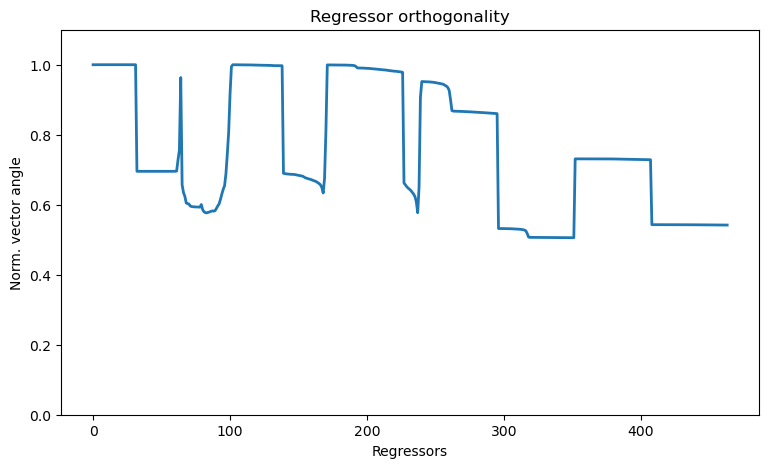

In [3]:
# Run QR and check for rank-defficiency. This will show whether a given regressor is highly collinear with other regressors in the design matrix.

"""
This section plots regressor orthogonality. The resulting plot ranges from 0 to 1 for each regressor, with 1 being
fully orthogonal to all preceeding regressors in the matrix and 0 being
fully redundant. Having fully redundant regressors in the matrix will
break the model, so those regressors are removed. In
practice, you should understand where the redundancy is coming from and
change your model design to avoid it in the first place!
"""

%matplotlib inline 

full_QRR, full_R, event_idx = rm.calc_regressor_orthogonality(full_R, event_idx, rmv = True) # Orthogonalize normalized design matrix and remove redundant regressors

rm.plot_regressor_orthogonality(full_QRR) # show how orthogonal individual regressors are to the rest of the matrix

np.savez(pjoin(localdisk, 'design'), full_R=full_R, event_idx=event_idx, event_labels=event_labels, event_types = event_types, full_QRR=full_QRR) # Save design matrix and event labels


In [4]:
# Run cross-validation

# Full model - this will take a moment
[full_m_stack, full_beta, _, full_idx, full_ridge, full_labels] = rm.cross_val_model(full_R, r_stack, event_labels, event_idx, event_labels, opts['n_folds'])
full_cvR2 = rm.model_corr(r_stack, full_m_stack)[0] ** 2 # Compare the real and model stacks

np.savez(pjoin(localdisk, 'full_m'), U=full_m_stack.U, SVT=full_m_stack.SVT, beta=full_beta, R=full_R, idx=full_idx, ridge=full_ridge, labels=full_labels, cvR2 = full_cvR2) # save the results

Performing cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

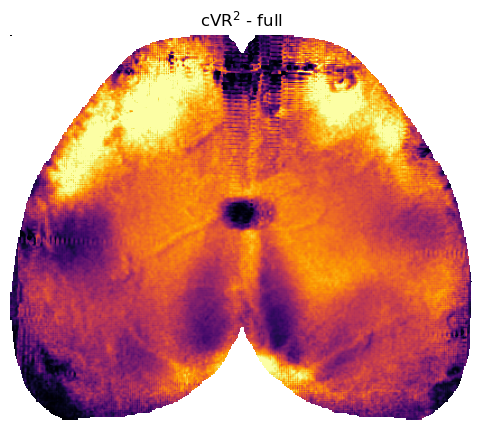

In [5]:
# Show R^2 results

%matplotlib inline

rm.plot_model_corr(full_cvR2, 'full')